In [ ]:
!pip3 install matplotlib
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip3 install numpy
!pip3 install nest_asyncio
!pip3 install networkx

In [53]:
import json
import twint
import nest_asyncio
from collections import Counter
import pandas as pd
pd.set_option('display.max_colwidth', 0)
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx

# File path

In [57]:
file_path = "../data/twint/2019_#uberlyftstrike_april_and_may.txt"

## 1. Get most popular Uber-related hashtags

### Hashtags and their occurrences

Total number of tweets: 4337
Number of tweets without hashtags: 0


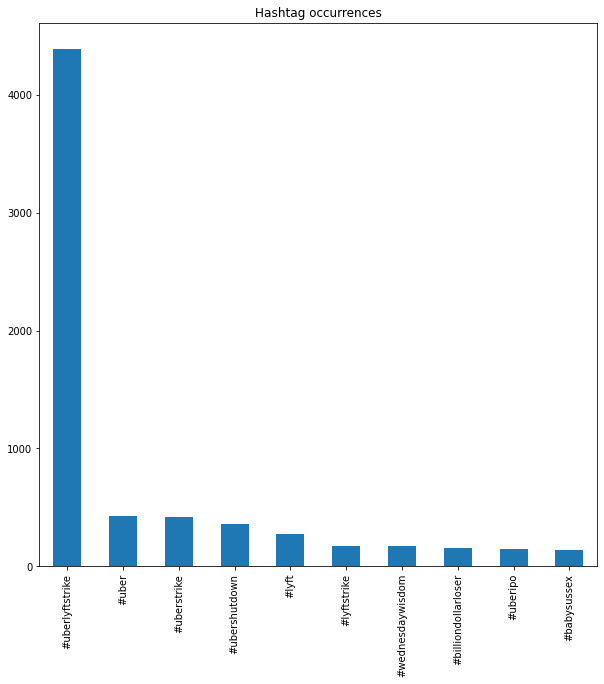

In [58]:
tweets = []
tweets_without_hashtags = []
all_hashtags = []
hashtag_pairs = []
with open(file_path) as f:
    for line in f:
        tweet = json.loads(line)
        tweets.append(tweet)
        hashtags = tweet['hashtags']
        pairs = combinations(hashtags, r=2)
        for pair in pairs:
            hashtag_pairs.append(pair)
        for h in hashtags:
            all_hashtags.append(h)
        if len(hashtags) == 0:
            tweets_without_hashtags.append(tweet)
                    
print("Total number of tweets: %d" % len(tweets))
print("Number of tweets without hashtags: %d" % len(tweets_without_hashtags))
    
hashtags_counter = Counter(all_hashtags)
hashtag_count_df = pd.DataFrame.from_dict(hashtags_counter, orient='index', columns=['count']).sort_values(by=['count'], ascending=False).head(10)
hashtag_count_df.plot(kind='bar', legend=False, title='Hashtag occurrences', figsize=(10, 10))
plt.show()

### Hashtag co-ocurrences

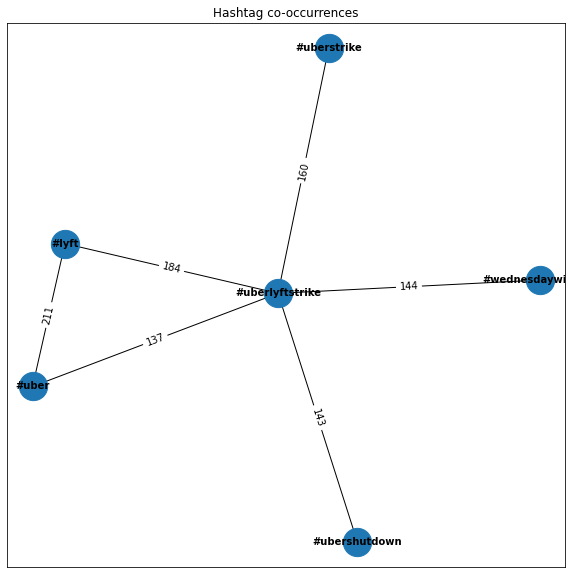

In [77]:
pairs_counter = Counter(hashtag_pairs)

hashtags_in_most_common_pairs = []
for t in pairs_counter.most_common(10):
    hashtags_in_most_common_pairs.append(t[0][0])
    hashtags_in_most_common_pairs.append(t[0][1])
    
hashtags_in_most_common_pairs = list(set(hashtags_in_most_common_pairs))

G = nx.Graph()
G.add_nodes_from(hashtags_in_most_common_pairs)
G.add_weighted_edges_from([(t[0][0], t[0][1], pairs_counter[t[0]]) for t in pairs_counter.most_common(10)])
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
plt.figure(1, figsize=(10, 10))
nx.draw_networkx(G,pos, font_size=10, font_weight='bold', node_size=800, title='sddf')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, width=10, font_size=10)
plt.title('Hashtag co-occurrences')
plt.show()

## 3. Create their timelines

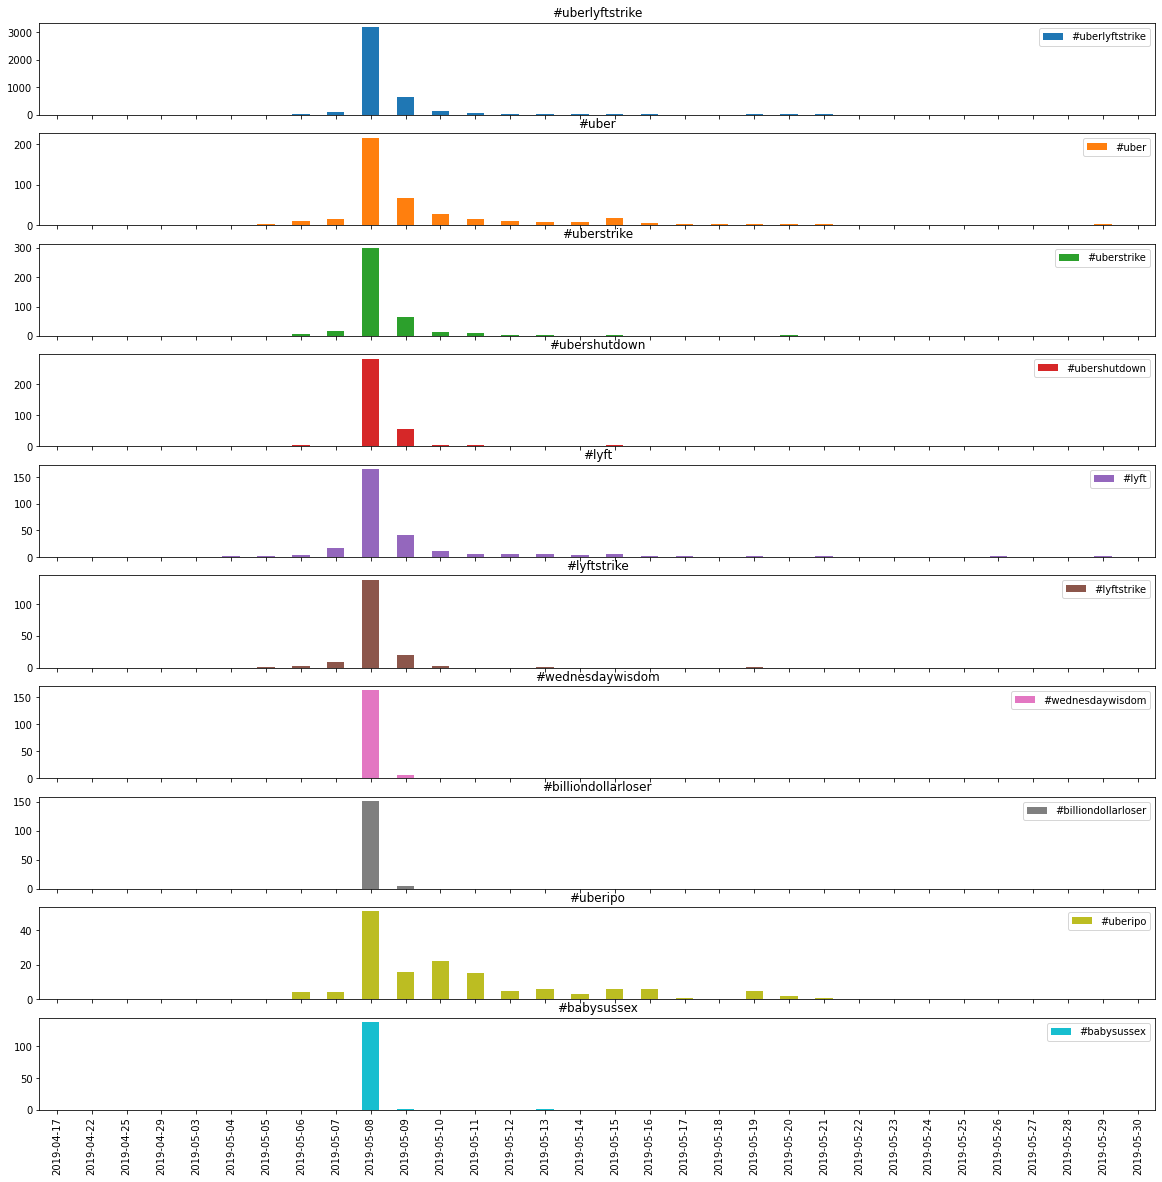

In [62]:
hashtags_dates = {}
unique_hashtags = set(all_hashtags)
for hashtag in unique_hashtags:
    hashtags_dates[hashtag] = {}

all_dates = [t['date'] for t in tweets]
for d in all_dates:
    for h in hashtags_dates.keys():
        hashtags_dates[h][d] = 0

for t in tweets:
    hashtags = t['hashtags']
    date = t['date']
    for h in hashtags:
        count = hashtags_dates[h][date]
        if count == 0:
            hashtags_dates[h][date] = 1
        else:
            hashtags_dates[h][date] += 1
            
# Plot
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Grouper
from pylab import rcParams

rcParams['figure.figsize'] = 20, 20

dfs = {}
""""
for hashtag, date_counts in hashtags_dates.items():
    df = pd.DataFrame.from_dict(date_counts, orient='index', columns=['count'])
    dfs[hashtag] = df
"""

df = pd.DataFrame.from_dict(hashtags_dates, orient='index')
df['total'] = df[list(df.columns)].sum(axis=1)
df = df.sort_values(by=['total'], ascending=False)

top_10 = df.head(10).transpose()[::-1].drop(['total'])
top_10
top_10.plot(subplots=True, kind='bar')
plt.show()

### 4. Look into the most active users

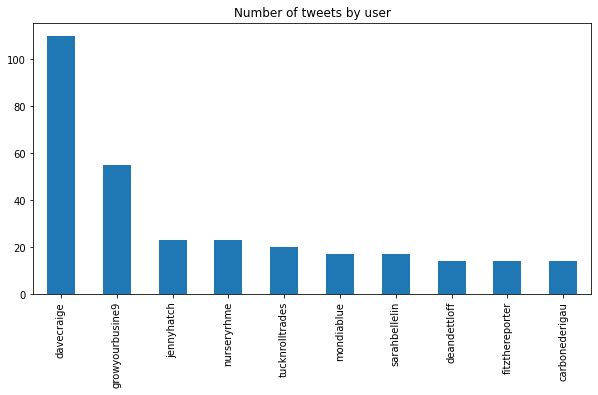

,username,tweets,name,following,followers,bio,url
0,davecraige,110,Dave Craige ⚡️,6387,7767,"🔨 Building @TheStudio_io, @Help_Hospitals & @HelpEcuador_ . Be Kind. ✉️ http://Dave.Substack.com ▶️ http://Youtube.com/DaveCraige .",http://TheStudio.io/Discord
1,GrowYourBusine9,55,Grow Your Business Online,136,14,,
2,JennyHatch,23,Jenny Marie Hatch 🇺🇸,95,2465,Blogging Mama Singing and Dancing in my Kitchen...,http://JennyHatch.com
3,nurseryrhme,23,Carol slocum,2194,1236,,
4,tucknrolltrades,20,tucknrolltrades,1752,356,Freedom maximalist. All tweets are my opinion and are prolly not be taken as financial advice.,
5,Mondiablue,17,MONDIA BLUE,7535,9457,I AM VOTING GREEN PARTY!!! $mondiablue,
6,SarahBelleLin,17,Sarah Belle Lin,1644,2629,Bay Area-Based Community Reporter/Photographer. I'm on Signal and ProtonMail. Message me for my contact info.,https://sarahbelle909.journoportfolio.com
7,DeanDettloff,14,Dean Dettloff,1625,4383,Sessional Lecturer @InsChr - Philosophy/Marxism/Media - Catholic - Co-Host @TheMagnificast - Writing in @americamag @sojourners @commonwealmag @GeezMagazine etc,http://deandettloff.com
8,FitzTheReporter,14,Joe Fitzgerald Rodriguez,5695,16043,"#SF raised. KQED Producer/Reporter, @SPJ_NorCal VP, reporting the hell out of my dear, foggy City. jrodriguez@kqed.org / 88.5 FM / DM for Signal info",http://www.KQED.org
9,carbonederigau,14,La Acera,650,767,,


In [115]:
nest_asyncio.apply()

user_counter = Counter([t['username'] for t in tweets])
user_counter_df = pd.DataFrame.from_dict(user_counter, orient='index', columns=['tweets']).sort_values(by=['tweets'], ascending=False).head(10)
user_counter_df.plot(kind='bar', legend=False, title='Number of tweets by user', figsize=(10, 5))
plt.show()

c = twint.Config()
c.Store_object = True
c.Hide_output = True
users = []
twint.output.users_list = []

for username in user_counter_df.index:
    c.Username = username
    twint.run.Lookup(c)

users = twint.output.users_list
users_df = pd.DataFrame({'username': [user.username for user in users],
                         'tweets': [user_counter[user.username.lower()] for user in users],
                         'name': [user.name for user in users],
                         'following': [user.following for user in users],
                         'followers': [user.followers for user in users],
                         'bio': [user.bio for user in users],
                         'url': [user.url for user in users]})
users_df